In [62]:
%load_ext autoreload
%autoreload 2

from util_0730 import *
from myalgorithm_0730_1 import algorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_1.json'
# problem_file = '../alg_test_problems_20240429/TEST_K200_1.json'

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

for v in ALL_RIDERS:
    print(v)

print(K)

Rider([BIKE, 5.291005291005291, 100, 60, 8000, 120, 20])
Rider([WALK, 1.3227513227513228, 70, 30, 8000, 120, 30])
Rider([CAR, 4.2328042328042335, 200, 100, 6000, 180, 100])
100


In [69]:
## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

## ------------------  크루스칼 함수   -----------------------------

def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function):
    def find(v):
        while v != parent[v]:
            parent[v] = parent[parent[v]]
            v = parent[v]

        return v

    def union(a, b, new_bundle):
        if a > b:
            a, b = b, a

        parent[b] = a
        all_bundles[a] = new_bundle

    for i in range(len(all_bundles)):
        bundle = all_bundles[i]

        shop_seq = bundle.shop_seq

        xs_s_sum = 0
        ys_s_sum = 0

        xs_e_sum = 0
        ys_e_sum = 0

        readytimes_sum = 0
        deadlines_sum = 0

        shop_seq_len = len(shop_seq)

        for order_num in shop_seq:
            order = ALL_ORDERS[order_num]

            xs_s_sum += order.shop_lat
            ys_s_sum += order.shop_lon

            xs_e_sum += order.dlv_lat
            ys_e_sum += order.dlv_lon

            readytimes_sum += order.ready_time
            deadlines_sum += order.deadline

        xs_s_avg = xs_s_sum / shop_seq_len
        ys_s_avg = ys_s_sum / shop_seq_len

        xs_e_avg = xs_e_sum / shop_seq_len
        ys_e_avg = ys_e_sum / shop_seq_len

        readytimes_avg = readytimes_sum / shop_seq_len
        deadlines_avg = deadlines_sum / shop_seq_len

        avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

        bundle.avg_info = avg_info

    edges = []
    for i in range(len(all_bundles)):
        for j in range(i + 1, len(all_bundles)):
            avg_info1 = all_bundles[i].avg_info
            avg_info2 = all_bundles[j].avg_info

            sx1, sy1, ex1, ey1, r1, d1 = avg_info1
            sx2, sy2, ex2, ey2, r2, d2 = avg_info2

            r_diff = abs(r1 - r2)
            d_diff = abs(d1 - d2)

            start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

            if avg_method == 'avg':
                dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
            elif avg_method == 'two_seq':
                dist1 = DIST[i][j]
                dist2 = DIST[i + K][j + K]
            elif avg_method == 'two':
                order_num1 = all_bundles[i].shop_seq[0]
                order_num2 = all_bundles[j].shop_seq[0]

                dist1 = DIST[order_num1][order_num2]
                dist2 = DIST[order_num1 + K][order_num2 + K]  
            else:
                assert False

            # weight1 = (dist1 + dist2) / 900

            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2
            diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1
            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1

            edges.append((i, j, diff_score))

    parent = list(range(len(all_bundles)))
    edges.sort(key=lambda x: x[2])

    for bundle_num1, bundle_num2, diff_score in edges:
        rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

        if rbn1 == rbn2:
            continue

        new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

        if new_bundle is not None:
            all_bundles[rbn1].rider.available_number += 1
            all_bundles[rbn2].rider.available_number += 1
            
            new_bundle.rider.available_number -= 1

            union(rbn1, rbn2, new_bundle)

    parent = [find(v) for v in parent]

    result_bundles = [all_bundles[v] for v in set(parent)]
    rider_availables = [rider.available_number for rider in ALL_RIDERS]

    return result_bundles, rider_availables

## --------------- 초기 번들링 최적화 코드 --------------------------

weight1 = 1
weight2 = -2.5

avg_method = 'two'
bundle_merging_function = try_merging_bundles_by_dist_with_walk_car_prefered
default_get_dist_function = get_dist_by_coords

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

# 2개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function)

# 4개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, 'avg', all_bundles, default_get_dist_function)

# 2개 이하 주문이 묶인 번들을 전부 푼 다음 다시 생성
new_all_bundles = []
for bundle in all_bundles:
    if len(bundle.shop_seq) >= 3:
        new_all_bundles.append(bundle)
    else:
        old_rider = bundle.rider
        old_rider.available_number += 1
        for order_num in bundle.shop_seq:
            order = ALL_ORDERS[order_num]

            new_bundle = Bundle(ALL_ORDERS, car_rider, [order.id], [order.id], order.volume, DIST[order.id, order.id + K])
            car_rider.available_number -= 1
            new_all_bundles.append(new_bundle)

# print('#remain\n')

all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', new_all_bundles, default_get_dist_function)

## ------------------- 라이더 재배치 -------------------------------

all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

In [70]:
checked_solution

{'total_cost': 375603.4000000001,
 'avg_cost': 3756.034000000001,
 'num_drivers': 36,
 'total_dist': 165573,
 'feasible': True,
 'infeasibility': None,
 'bundles': [['CAR', [12, 0], [0, 12]],
  ['CAR', [1, 41], [1, 41]],
  ['BIKE', [17, 2, 39], [17, 39, 2]],
  ['CAR', [3], [3]],
  ['CAR', [4, 13, 9], [4, 9, 13]],
  ['CAR', [5, 26], [5, 26]],
  ['CAR', [6], [6]],
  ['BIKE', [30, 24, 37], [30, 24, 37]],
  ['BIKE', [7, 18, 8], [8, 7, 18]],
  ['BIKE', [10, 28, 32, 11], [11, 28, 10, 32]],
  ['CAR', [14, 46, 40], [14, 46, 40]],
  ['CAR', [15, 23, 34, 20], [23, 15, 20, 34]],
  ['BIKE', [21, 38, 45, 16], [38, 21, 16, 45]],
  ['BIKE', [19, 33, 22], [22, 19, 33]],
  ['BIKE', [25, 52, 66, 50], [52, 25, 50, 66]],
  ['BIKE', [42, 47, 29], [29, 42, 47]],
  ['BIKE', [59, 49, 54], [54, 59, 49]],
  ['CAR', [43, 48, 31], [48, 43, 31]],
  ['BIKE', [53, 58, 35, 62], [35, 53, 58, 62]],
  ['CAR', [51, 44, 36], [51, 44, 36]],
  ['BIKE', [55, 77, 80], [55, 80, 77]],
  ['CAR', [61, 82], [82, 61]],
  ['CAR', [5

In [65]:
ALL_ORDERS

[Order([0, 17, 37.48840995, 127.10295635, 37.487094, 127.083614, 20, 900, 2864]),
 Order([1, 72, 37.48607473, 126.98260625, 37.498741, 127.003332, 38, 600, 2816]),
 Order([2, 79, 37.49599101, 127.02524098, 37.513189999999994, 127.014811, 16, 600, 2762]),
 Order([3, 97, 37.49588029, 127.04646128, 37.508556, 127.046488, 32, 600, 2544]),
 Order([4, 119, 37.5100446, 127.00707557, 37.506882, 127.013972, 28, 900, 2632]),
 Order([5, 138, 37.4939637, 127.03815653, 37.484053, 127.042324, 23, 300, 2203]),
 Order([6, 190, 37.46882778, 127.04121252, 37.488474999999994, 127.055236, 9, 300, 2701]),
 Order([7, 194, 37.494785, 127.035206, 37.493728, 127.031346, 24, 1200, 2893]),
 Order([8, 199, 37.5155446, 127.04232221, 37.511381, 127.04472, 13, 900, 2647]),
 Order([9, 233, 37.50232363, 127.02690732, 37.511444999999995, 127.057029, 64, 900, 3455]),
 Order([10, 236, 37.48279755, 126.99491078, 37.484562999999994, 127.013489, 25, 1800, 3963]),
 Order([11, 245, 37.51532367, 127.1127047, 37.493244, 127.075

In [66]:
checked_solution['avg_cost']

3411.8789999999995

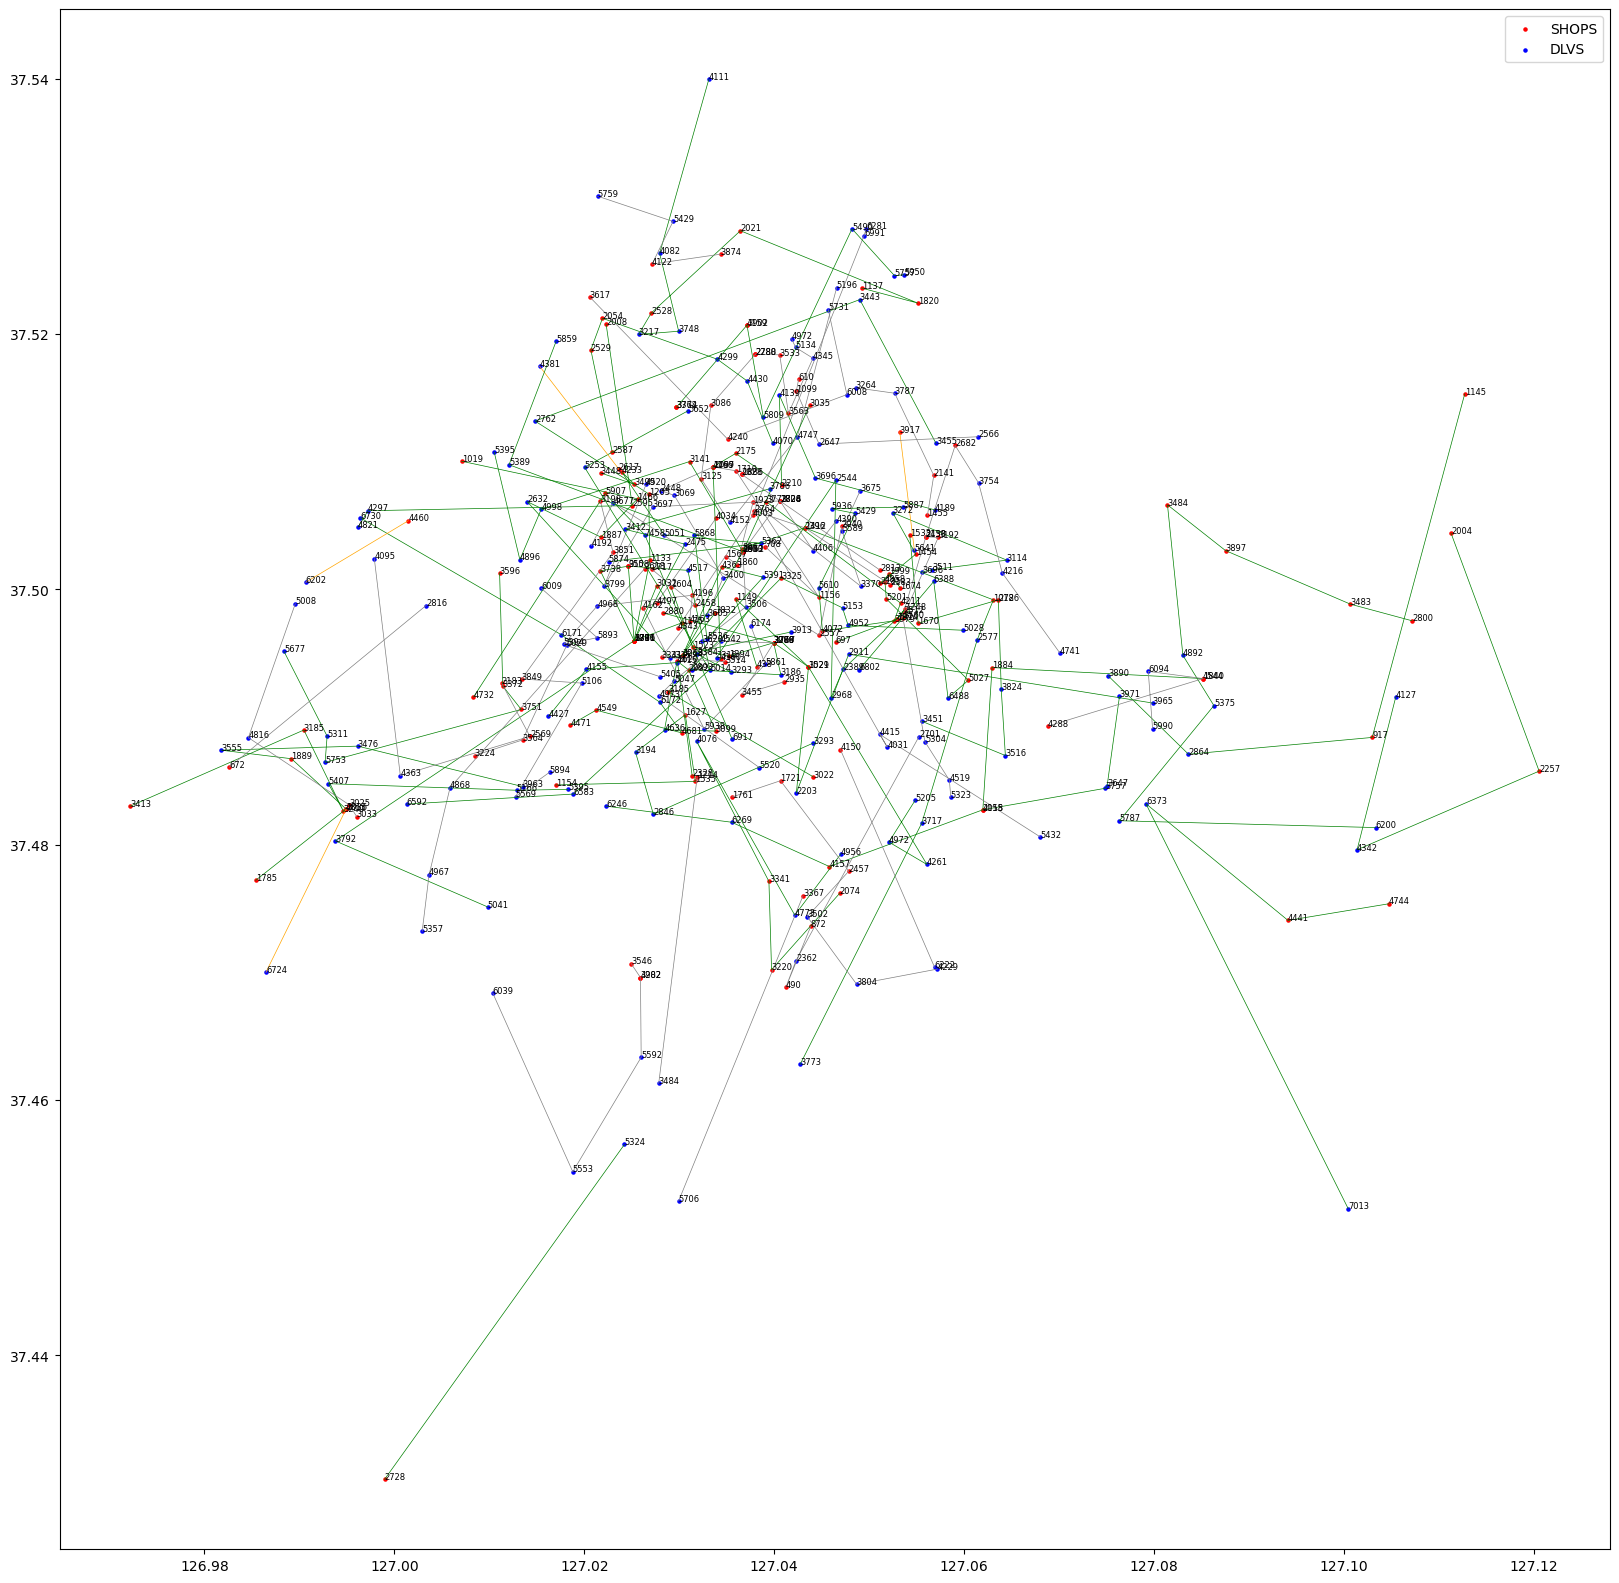

In [67]:
draw_route_solution3(ALL_ORDERS, checked_solution)